In [37]:
import enum
import numpy as np
import math
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from colors import *
import numpy.linalg as la


class ecosystem_nonspeciating:

    def __init__(self, 
                GAMMA = None,
                D_DIMENSION = 5, 
                P_NORM = 1, 
                K_SPECIES_MAX = 100,
                ABUNDANCE_SPAWN = 0.01,
                ABUNDANCE_DEATH = 0.001, #Abundance below threshold --> species extinct.
                DEATH_RATE = 0.1,
                ALPHA = 0.05,
                BETA = 0.01,
                DT_TIMESCALE = 0.001,
                SEED = None,
                MONOD = False, 
                MONOD_HALF_VELOCITY = None, 
                MONOD_ALPHAMAX = None,
                MONOD_BETAMAX = None,
                save_every = 10,
                result_folder = "results"
                ):

        self.GAMMA = GAMMA
        self.D_DIMENSION = D_DIMENSION
        self.P_NORM = P_NORM
        self.K_SPECIES_MAX = K_SPECIES_MAX
        self.ABUNDANCE_SPAWN = ABUNDANCE_SPAWN
        self.ABUNDANCE_DEATH = ABUNDANCE_DEATH
        self.DEATH_RATE = DEATH_RATE
        self.ALPHA = ALPHA
        self.BETA = BETA
        self.DT_TIMESCALE = DT_TIMESCALE
        self.SEED = SEED
        self.MONOD = MONOD
        self.MONOD_HALF_VELOCITY = MONOD_HALF_VELOCITY
        self.MONOD_ALPHAMAX = MONOD_ALPHAMAX
        self.MONOD_BETAMAX = MONOD_BETAMAX
        self.save_every = save_every
        self.result_folder = result_folder
       
        self.time = 0
        self.RNG = np.random.default_rng(seed=self.SEED)
        self.strategies = self.RNG.exponential(size=(K_SPECIES_MAX, D_DIMENSION))
        for i, strat in enumerate(self.strategies):
            self.strategies[i] = strat/la.norm(strat, ord=P_NORM) #vector containing the strategy vectors
        self.abundances = np.ones(K_SPECIES_MAX)  * ABUNDANCE_SPAWN
        self.resources = np.ones(D_DIMENSION)  #vector containing resource abundances, maybe this is too much for initialization
        self.interarrival_times = np.zeros(K_SPECIES_MAX)
        self.alive = np.ones(K_SPECIES_MAX) #1 if species at ID is alive, 0 if it's not.
        self.start = datetime.now().strftime("%d%m_%H%M%S")
        self.results_csv = result_folder+"/{}_results_nonspeciating.csv".format(self.start)

        if GAMMA is None:
            GAMMA = self.RNG.exponential(size=D_DIMENSION)
            self.GAMMA = GAMMA/la.norm(GAMMA, ord=P_NORM)
        
        if len(GAMMA) != D_DIMENSION:
            raise ValueError(f"GAMMA needs to be of length {D_DIMENSION}.")

        if MONOD:
            self.ALPHA = None
            self.BETA = None
        
        '''write header for csv result file'''
        with open(self.results_csv, 'a', newline='') as csvfile:
            testwriter = csv.writer(csvfile, delimiter=',')
            testwriter.writerow(["time"] + ["resource"+str(i) for i in range(self.D_DIMENSION)]  + ["species"+str(j) for j in range(self.K_SPECIES_MAX)])

        '''initialize counters for efficient storage of results'''
        self.STORAGE_SIZE = 1000
        self.STORAGE_COUNTER = 0
        self.RESULTS = np.ones((self.STORAGE_SIZE, 1+self.D_DIMENSION+self.K_SPECIES_MAX))

        self.RESULTS[self.STORAGE_COUNTER, 0] = 0
        self.RESULTS[self.STORAGE_COUNTER, 1:self.D_DIMENSION+1] = self.resources
        self.RESULTS[self.STORAGE_COUNTER, self.D_DIMENSION+1:1+self.D_DIMENSION+self.K_SPECIES_MAX] = self.abundances

        self.STORAGE_COUNTER += 1

        with open(self.result_folder+"/PARAMETER_SETTINGS.csv", 'a', newline='') as csvfile:
                testwriter = csv.writer(csvfile, delimiter=',')
                testwriter.writerow([self.start, self.GAMMA, self.D_DIMENSION, self.P_NORM, self.K_SPECIES_MAX, self.ABUNDANCE_SPAWN, self.ABUNDANCE_DEATH, self.DEATH_RATE, self.ALPHA, self.BETA, self.DT_TIMESCALE, self.SEED, self.MONOD, self.MONOD_HALF_VELOCITY, self.MONOD_ALPHAMAX, self.MONOD_BETAMAX, self.save_every])
    
    def update_system(self, timesteps):
        '''Integrates system in between speciation events'''

        while self.time < timesteps:
            
            '''Empty storage array if full'''
            if self.STORAGE_COUNTER == self.STORAGE_SIZE:
                with open(self.results_csv, 'a', newline='') as csvfile:
                    testwriter = csv.writer(csvfile, delimiter=',')
                    testwriter.writerows(self.RESULTS)
                    self.STORAGE_COUNTER = 0

            '''update system'''
            self.resources += (self.GAMMA - self.BETA * np.dot(np.array(self.abundances), np.array(self.strategies))) * self.DT_TIMESCALE
            self.abundances += (self.ALPHA * (np.dot(np.array(self.strategies), np.array(self.resources).T)) - self.DEATH_RATE * np.ones(len(self.strategies))) * np.array(self.abundances) * self.DT_TIMESCALE
            self.time += self.DT_TIMESCALE

            '''set resources and abundances to 0 if needed 
            must be done using event in solve_ivp'''
            for i, resource in enumerate(self.resources):
                if resource <= 0:
                    self.resources[i] = 0
            
            for i, abundance in enumerate(self.abundances):
                if abundance <= self.ABUNDANCE_DEATH:
                    self.abundances[i] = 0
                    self.alive[i] = 0

            '''save results every indicated timestep'''
            if round(self.time, int(round(np.log10(1/self.DT_TIMESCALE),0))) % self.save_every == 0:
                self.RESULTS[self.STORAGE_COUNTER, 0] = round(self.time,0)
                self.RESULTS[self.STORAGE_COUNTER, 1:self.D_DIMENSION+1] = self.resources
                self.RESULTS[self.STORAGE_COUNTER, self.D_DIMENSION+1:1+self.D_DIMENSION+self.K_SPECIES_MAX] = self.abundances                 
                self.STORAGE_COUNTER += 1

            '''stop simulation if system dies'''
            if np.sum(self.alive) == 0:
                break

        '''ensure that all results are included in the csv file'''
        with open(self.results_csv, 'a', newline='') as csvfile:
            testwriter = csv.writer(csvfile, delimiter=',')
            testwriter.writerows(self.RESULTS[:self.STORAGE_COUNTER, :])
            self.STORAGE_COUNTER = 0


            '''write strategies to file'''
        strategies_csv = self.result_folder+"/{}_strategies_nonspeciating.csv".format(self.start)
        with open(strategies_csv, 'a', newline='') as csvfile:
            testwriter = csv.writer(csvfile, delimiter=',')
            testwriter.writerow(["ID"] + ["strat_res"+str(i) for i in range(self.D_DIMENSION)] + ["alive_at_end"])
            for ID, strategy in enumerate(self.strategies):
                testwriter.writerow([ID] + [strat for strat in strategy] + [bool(self.abundances[ID])])
                                    
        


    def show_plots(self, cutoff=50):
        '''show plot for resource and species abundance over time
        cutoff specifies the number of first timesteps to ignore
        only in notebook'''

        
        df = pd.read_csv(self.results_csv)
        ax = plt.gca()
        ax.set_prop_cycle(colors_cycler)
        for i in range(self.D_DIMENSION):
            key = 'resource'+str(i)
            plt.plot(df.time[cutoff:], df[key][cutoff:])
        # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(self.result_folder+"/{}_resources.png".format(self.start))
        plt.show()

        ax = plt.gca()
        ax.set_prop_cycle(colors_cycler)
        for j in range(self.K_SPECIES_MAX):
            key = 'species'+str(j)
            plt.plot(df.time[cutoff:], df[key][cutoff:])
        plt.savefig(self.result_folder+"/{}_species.png".format(self.start))
        plt.show()

        ax = plt.gca()
        ax.set_prop_cycle(colors_cycler)
        for j in range(self.K_SPECIES_MAX):
            key = 'species'+str(j)
            plt.semilogy(df.time[cutoff:], df[key][cutoff:])
        plt.savefig(self.result_folder+"/{}_species_logy.png".format(self.start))
        plt.show()


    def print_stats(self):
        '''only in notebook'''
        print("Simulation started on ", self.start)
        print("Results stored in: ", self.results_csv)
        print("D_DIMENSION: ", self.D_DIMENSION)
        print("P_NORM: ", self.P_NORM)
        print("GAMMA: ", self.GAMMA)
        print("DT_TIMESCALE: ", self.DT_TIMESCALE)
        print("Living species: ", np.sum(self.alive))
        print("death_rate: ", self.DEATH_RATE)
        print("ID, strategies, alive,  abundance at end simulation:")
        for ID, strategy in enumerate(self.strategies):
            print(ID, strategy, self.alive[ID], self.abundances[ID])

        


In [38]:
with open("test/PARAMETER_SETTINGS.csv", 'w', newline='') as csvfile:
    testwriter = csv.writer(csvfile, delimiter=',')
    testwriter.writerow(["STARTTIME", "GAMMA", "D_DIMENSION", "P_NORM", "K_SPECIES_MAX", "ABUNDANCE_SPAWN", "ABUNDANCE_DEATH", "DEATH_RATE", "ALPHA", "BETA", "DT_TIMESCALE", "SEED", "MONOD", "MONOD_HALF_VELOCITY", "MONOD_ALPHAMAX", "MONOD_BETAMAX", "save_every"])


In [61]:
MA_test = ecosystem_nonspeciating(D_DIMENSION=3, K_SPECIES_MAX=12, P_NORM=1.1, DT_TIMESCALE=0.1, SEED=823459534661, save_every=1, result_folder="test")
MA_test.update_system(500)
            

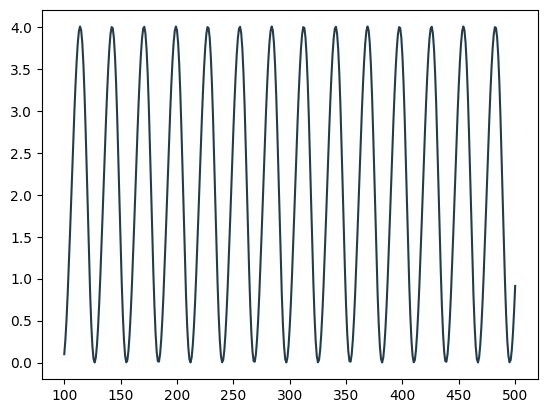

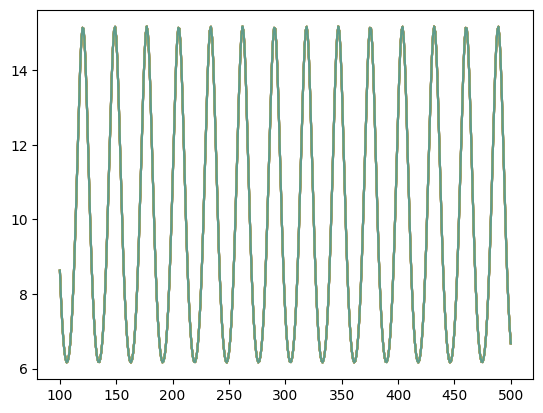

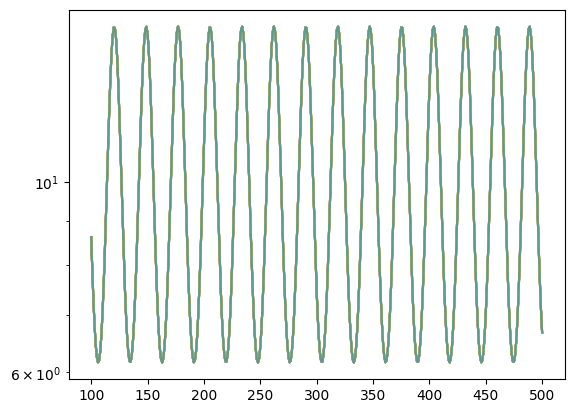

In [62]:
MA_test.show_plots(cutoff=100)

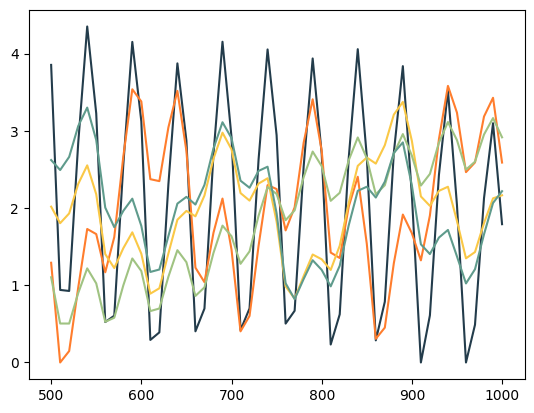

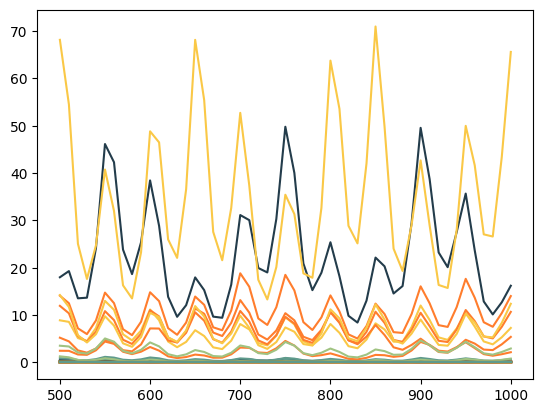

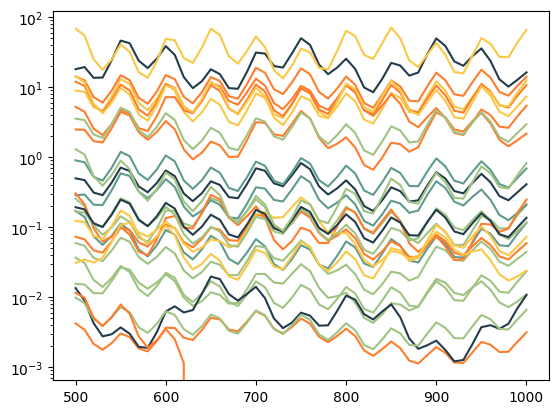

In [56]:

MA_test = ecosystem_nonspeciating([0.5, 0.2, 0.1, 0.1, 0.1], D_DIMENSION=5, DT_TIMESCALE=0.1, SEED=829561, result_folder="test")
MA_test.update_system(1000)
MA_test.show_plots()
        

In [ ]:
test = ecosystem_nonspeciating([0.5, 0.2, 0.1, 0.1, 0.1], D_DIMENSION=5, DT_TIMESCALE=0.1, SEED=829561)

In [93]:
df = MA_test.get_dataframe()

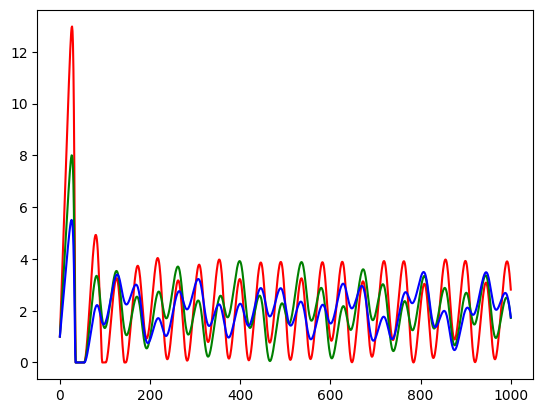

In [94]:
plt.plot(df.time, df.resource0, c='red')
plt.plot(df.time, df.resource1, c='green')
plt.plot(df.time, df.resource2, c='blue')
plt.show()

In [ ]:
MA_test.print_stats()

In [95]:
test1 = ecosystem_nonspeciating([0.5, 0.3, 0.2], D_DIMENSION=3, DT_TIMESCALE=0.1, SEED=1234)
test2 = ecosystem_nonspeciating([0.5, 0.3, 0.2], D_DIMENSION=3, DT_TIMESCALE=0.01, SEED=1234)
test1.update_system(1000)
test2.update_system(1000)
df1 = test1.get_dataframe()
df2 = test2.get_dataframe()

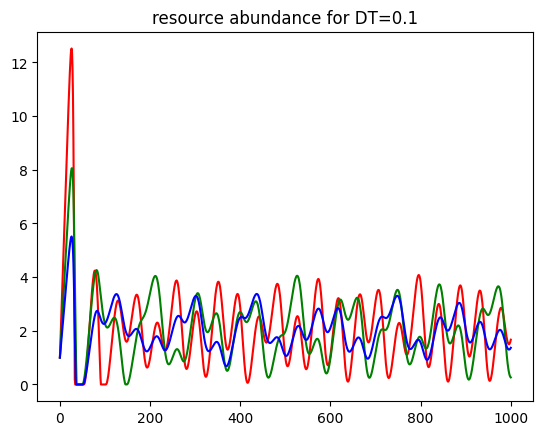

In [97]:
plt.plot(df1.time, df1.resource0, c='red')
plt.plot(df1.time, df1.resource1, c='green')
plt.plot(df1.time, df1.resource2, c='blue')
plt.title("resource abundance for DT=0.1")
plt.show()

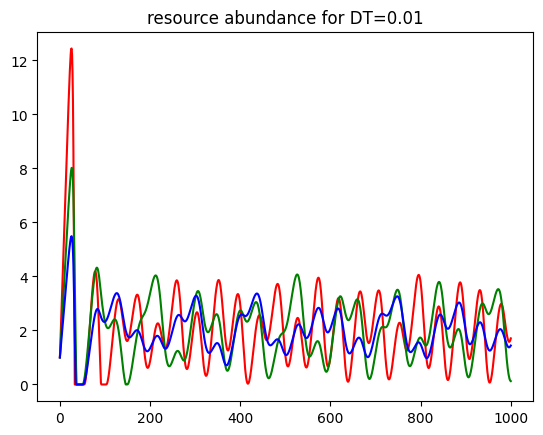

In [98]:
plt.plot(df2.time, df2.resource0, c='red')
plt.plot(df2.time, df2.resource1, c='green')
plt.plot(df2.time, df2.resource2, c='blue')
plt.title("resource abundance for DT=0.01")
plt.show()

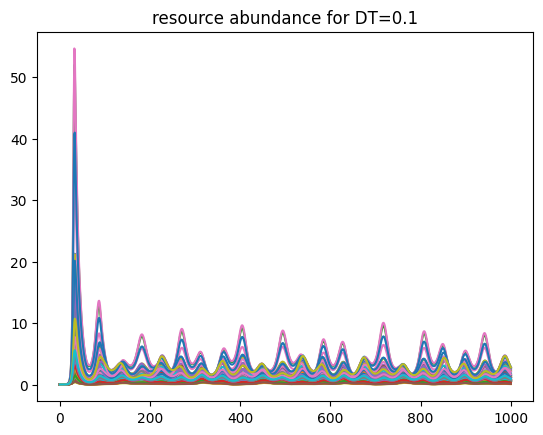

In [99]:
for j in range(test1.K_SPECIES_MAX):
    key = 'species'+str(j)
    plt.plot(df1.time, df1[key])
plt.title("resource abundance for DT=0.1")
plt.show()

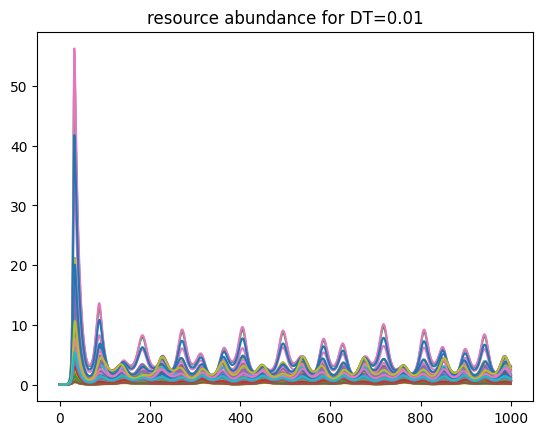

In [101]:
for j in range(test1.K_SPECIES_MAX):
    key = 'species'+str(j)
    plt.plot(df2.time, df2[key])
plt.title("resource abundance for DT=0.01")
plt.show()

In [102]:
test3 = ecosystem_nonspeciating([1,1,1], D_DIMENSION=3, SEED=234532351234)
test3.update_system(10000)
df3 = test3.get_dataframe()


In [103]:
test4 = ecosystem_nonspeciating([0.5, 0.3, 0.2], D_DIMENSION=3, SEED=234532351234)
test4.update_system(10000)
df4 = test4.get_dataframe()

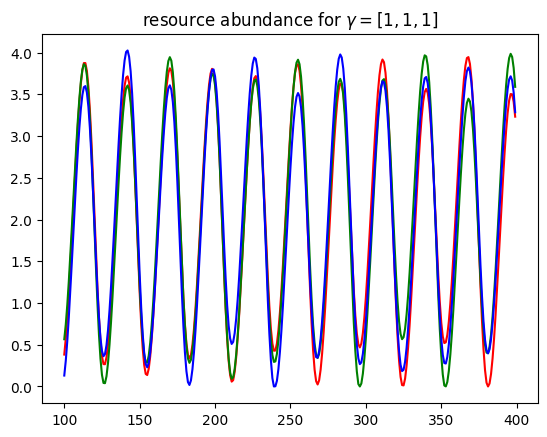

In [104]:
plt.plot(df3.time[100:400], df3.resource0[100:400], c='red')
plt.plot(df3.time[100:400], df3.resource1[100:400], c='green')
plt.plot(df3.time[100:400], df3.resource2[100:400], c='blue')
plt.title("resource abundance for $\gamma = [1, 1, 1]$")
plt.show()

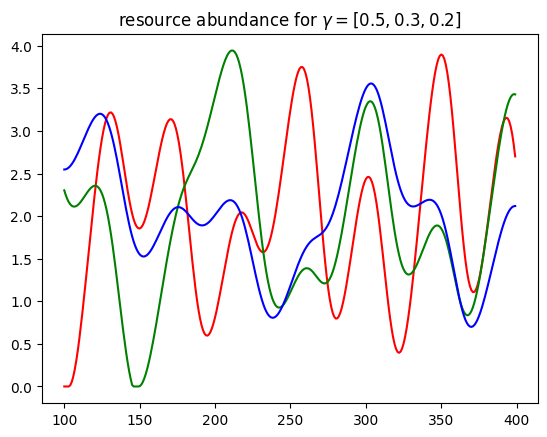

In [105]:
plt.plot(df4.time[100:400], df4.resource0[100:400], c='red')
plt.plot(df4.time[100:400], df4.resource1[100:400], c='green')
plt.plot(df4.time[100:400], df4.resource2[100:400], c='blue')
# plt.xlabel('time')
# plt.ylabel('resource abundance')
plt.title("resource abundance for $\gamma = [0.5, 0.3, 0.2]$")
plt.show()

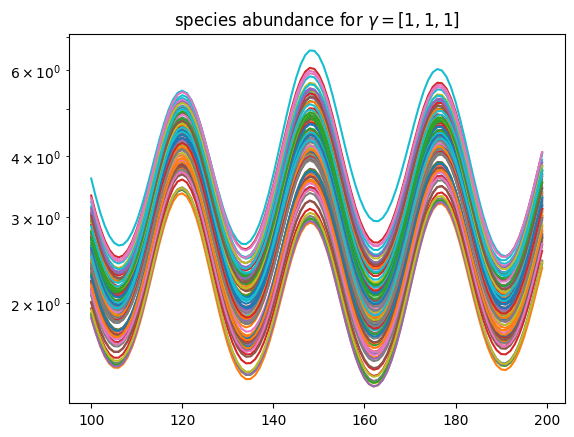

In [113]:
for j in range(test3.K_SPECIES_MAX):
    key = 'species'+str(j)
    plt.semilogy(df3.time[100:200], df3[key][100:200])
plt.title("species abundance for $\gamma = [1, 1, 1]$")
plt.show()

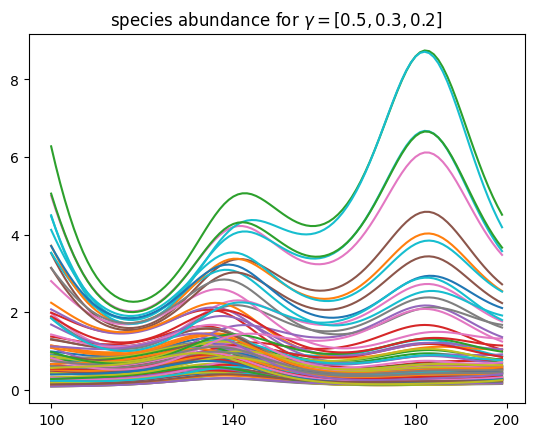

In [114]:
for j in range(test4.K_SPECIES_MAX):
    key = 'species'+str(j)
    plt.plot(df4.time[100:200], df4[key][100:200])
plt.title("species abundance for $\gamma = [0.5, 0.3, 0.2]$")
plt.show()

In [115]:
test5 = ecosystem_nonspeciating([1, 0, 0], D_DIMENSION=3, SEED=234532351234)
test5.update_system(700)
df5 = test5.get_dataframe()

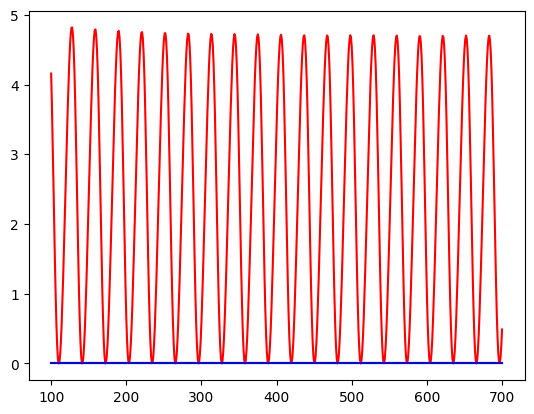

In [116]:
plt.plot(df5.time[100:], df5.resource0[100:], c='red')
plt.plot(df5.time[100:], df5.resource1[100:], c='green')
plt.plot(df5.time[100:], df5.resource2[100:], c='blue')
plt.show()


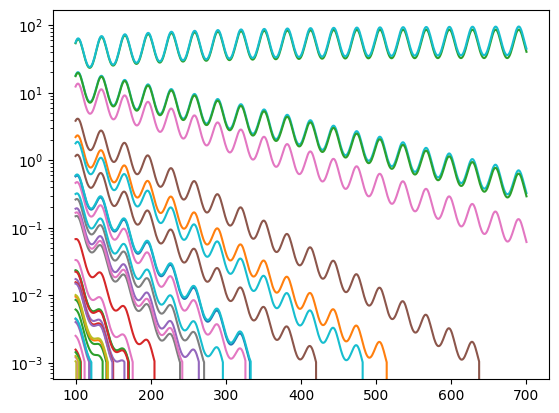

In [117]:
for j in range(test4.K_SPECIES_MAX):
    key = 'species'+str(j)
    plt.semilogy(df5.time[100:800], df5[key][100:800])
plt.show()

In [ ]:
test4.print_stats()

In [3]:
test = ecosystem_nonspeciating([0.1,0.2,0.33], P_NORM=0.5, D_DIMENSION=3, K_SPECIES_MAX=10, SEED=500, DT_TIMESCALE=0.05)

In [4]:
test.update_system(5000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


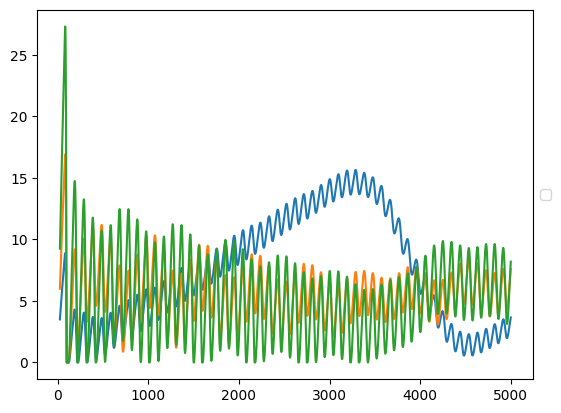

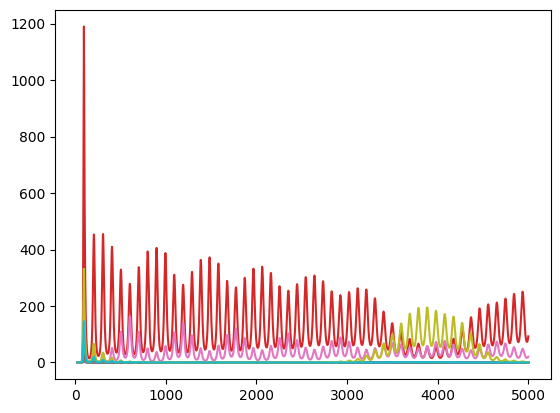

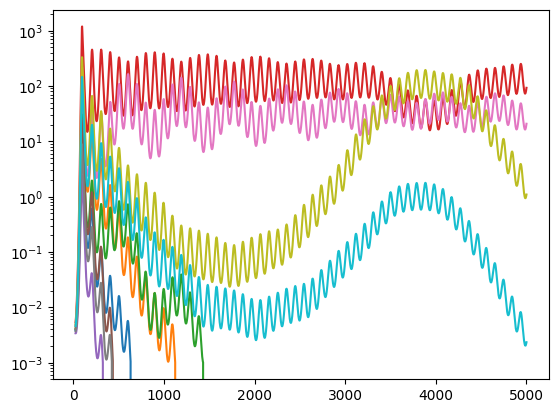

In [5]:
test.show_plots()